In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

In this notebook, you will learn how to load, explore, visualize, and pre-process a time-series dataset. The output of this notebook is a processed dataset that will be used in following notebooks to build a machine learning model.

### Dataset

[CTA - Ridership - Daily Boarding Totals](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97): This dataset shows systemwide boardings for both bus and rail services provided by Chicago Transit Authority, dating back to 2001.

### Objective

The goal is to forecast future transit ridership in the City of Chicago, based on previous ridership.

## Install packages and dependencies

Restarting the kernel may be required to use new packages.

In [2]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [56]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [57]:
# Enter your project and region. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'time-series-forecasting-306822' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-central-1' # REPLACE WITH YOUR REGION e.g. us-central1

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [58]:
target = 'y' # The variable you are predicting
target_description = 'Total Complaints' # A description of the target variable

raw_data_file = 'https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD'
processed_file = 'total_complaints.csv' # Which file to save the results to

## Load data

In [59]:
from google.cloud import bigquery as bq

sql = """
SELECT * FROM `bigquery-public-data.new_york_311.311_service_requests` LIMIT 5
"""

client = bq.Client(project=PROJECT)
df = client.query(sql).to_dataframe()

df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pickup_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,33473169,2016-05-30 23:04:36+00:00,2016-05-30 23:05:39+00:00,HRA,HRA Benefit Card Replacement,Benefit Card Replacement,Food Stamp,NYC Street Address,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
1,33473438,2016-05-30 20:36:00+00:00,2016-05-31 09:25:00+00:00,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
2,33477847,2016-05-31 12:17:00+00:00,2016-05-26 12:17:00+00:00,DOT,Department of Transportation,Street Light Condition,Street Light Out,None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
3,33473997,2016-05-30 05:12:00+00:00,2016-05-30 17:15:00+00:00,DEP,Department of Environmental Protection,Sewer,Highway Flooding (SH),None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
4,33473761,2016-05-30 12:36:00+00:00,2016-05-30 13:05:00+00:00,DEP,Department of Environmental Protection,Water System,Possible Water Main Break (Use Comments) (WA1),None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None


In [60]:
from google.cloud import bigquery as bq

sql = """
SELECT
  COUNT(unique_key) as y,
  DATE_TRUNC(DATE(created_date), month) as ds  
FROM `bigquery-public-data.new_york_311.311_service_requests`
GROUP by ds ORDER BY ds asc
"""
client = bq.Client(project=PROJECT)
df = client.query(sql).to_dataframe()

df.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


In [61]:
# from google.cloud import bigquery as bq

# sql = """
# SELECT * FROM `bigquery-public-data.new_york_311.311_service_requests` 
# """
# sql = """
# SELECT
#   COUNT(unique_key) as y,
#   DATE_TRUNC(DATE(created_date), month) as ds  
# FROM `bigquery-public-data.new_york_311.311_service_requests`
# GROUP by ds ORDER BY ds asc
# """
# client = bq.Client(project=PROJECT)
# df = client.query(sql).to_dataframe()

# df.head()

In [62]:
# Drop duplicates

df = df.drop_duplicates()

In [63]:
# Sort by date

df = df.sort_index()

## Explore data

In [64]:
# Print the top 5 rows

df.head()

,y,ds
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


### TODO 1: Analyze the patterns

* Is ridership changing much over time?
* Is there a difference in ridership between the weekday and weekends?
* Is the mix of bus vs rail ridership changing over time?

In [65]:
# Initialize plotting

register_matplotlib_converters() # Addresses a warning
sns.set(rc={'figure.figsize':(16,4)})

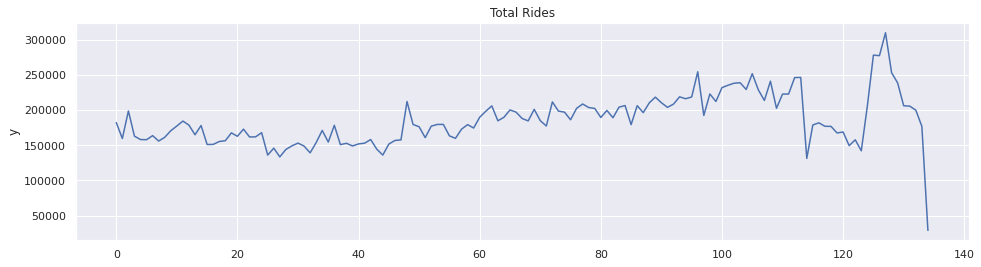

In [66]:
# Explore total rides over time

sns.lineplot(data=df, x=df.index, y=df[target]).set_title('Total Rides')
fig = plt.show()

### TODO 2: Review summary statistics

* How many records are in the dataset?
* What is the average # of riders per day?

In [67]:
df[target].describe().apply(lambda x: round(x))

count       135
mean     185675
std       35593
min       29016
25%      159626
50%      179514
75%      205920
max      309696
Name: y, dtype: int64

### Auto-correlation

Next, we will create an auto-correlation plot, to show how correlated a time-series is with itself. Each point on the x-axis indicates the correlation at a given lag. The shaded area indicates the confidence interval.

Note that the correlation gradually decreases over time, but reflects weekly seasonality (e.g. `t-7` and `t-14` stand out).

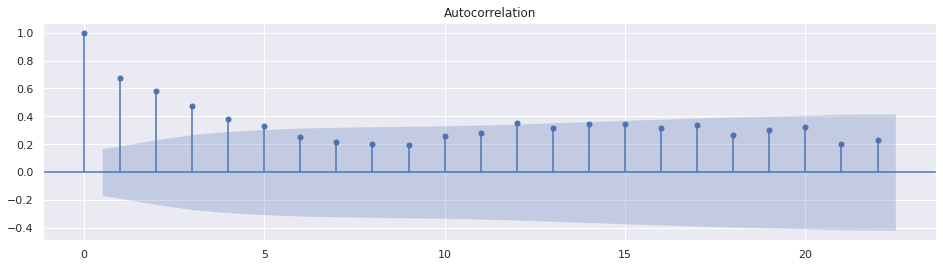

In [68]:
plot_acf(df[target])

fig = plt.show()

## Export data

This will generate a CSV file, which you will use in the next labs of this quest.
Inspect the CSV file to see what the data looks like.

In [69]:
df[[target]].to_csv(processed_file, index=True, index_label=ts_col)

## Conclusion

You've successfully completed the exploration and visualization lab.
You've learned how to:
* Create a query that groups data into a time series
* Visualize data
* Decompose time series into trend and seasonal components